In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Roboto Thin"
    }
</style>

<center>
<h1> SuGaR: Surface-Aligned Gaussian Splatting for Efficient 3D Mesh Reconstruction 
    <br>and High-Quality Mesh Rendering</h1>
Antoine Guédon and Vincent Lepetit

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    AmbientLights,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    )
from pytorch3d.renderer.blending import BlendParams
from sugar_scene.gs_model import GaussianSplattingWrapper
from sugar_scene.sugar_model import SuGaR, load_refined_model
from sugar_utils.spherical_harmonics import SH2RGB

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using original 3DGS rasterizer from Inria.


In [3]:
numGPU = 0
torch.cuda.set_device(numGPU)

# Load data and vanilla Gaussian Splatting

In [4]:
# ========== Loading parameters ==========
use_eval_split = False
n_skip_images_for_eval_split = 8

iteration_to_load = 7000
# iteration_to_load = 30_000

load_gt_images = False
use_custom_bbox = False

Choose a data directory (the directory that contains the images subdirectory).

In [8]:
# Example
source_path = './dataset/undistorted/'

Choose a corresponding vanilla Gaussian Splatting checkpoint directory.

In [9]:
# Example
gs_checkpoint_path = './output/vanilla_gs/undistorted/'

Load data and 3DGS checkpoint.

In [10]:
# ====================Load NeRF model and training data====================

# Load Gaussian Splatting checkpoint 
print(f"\nLoading config {gs_checkpoint_path}...")
if use_eval_split:
    print("Performing train/eval split...")
nerfmodel = GaussianSplattingWrapper(
    source_path=source_path,
    output_path=gs_checkpoint_path,
    iteration_to_load=iteration_to_load,
    load_gt_images=load_gt_images,
    eval_split=use_eval_split,
    eval_split_interval=n_skip_images_for_eval_split,
    )

print(f'{len(nerfmodel.training_cameras)} training images detected.')
print(f'The model has been trained for {iteration_to_load} steps.')
print(len(nerfmodel.gaussians._xyz) / 1e6, "M gaussians detected.")


Loading config ./output/vanilla_gs/undistorted/...
Found image extension .jpg
251 training images detected.
The model has been trained for 7000 steps.
2.012811 M gaussians detected.


# Render with a refined SuGaR model

Choose a corresponding refined SuGaR checkpoint directory (located in `refined/<your scene>`)

In [11]:
# Example
refined_sugar_folder = "./output/refined/undistorted/sugarfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1/"

Choose a refinement iteration to load.

In [12]:
refined_iteration_to_load = 15_000

Load the refined SuGaR checkpoint.

In [13]:
refined_sugar_path = os.path.join(refined_sugar_folder, f"{refined_iteration_to_load}.pt")
print(f"\nLoading config {refined_sugar_path}...")

refined_sugar = load_refined_model(refined_sugar_path, nerfmodel)


Loading config ./output/refined/undistorted/sugarfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1/15000.pt...
Loading refined model...
1460317 faces detected.
1460317 gaussians detected.
1 gaussians per surface triangle detected.
Binding radiance cloud to surface mesh...


Render an image.

Rendering image with index 102.
Image name: 000103


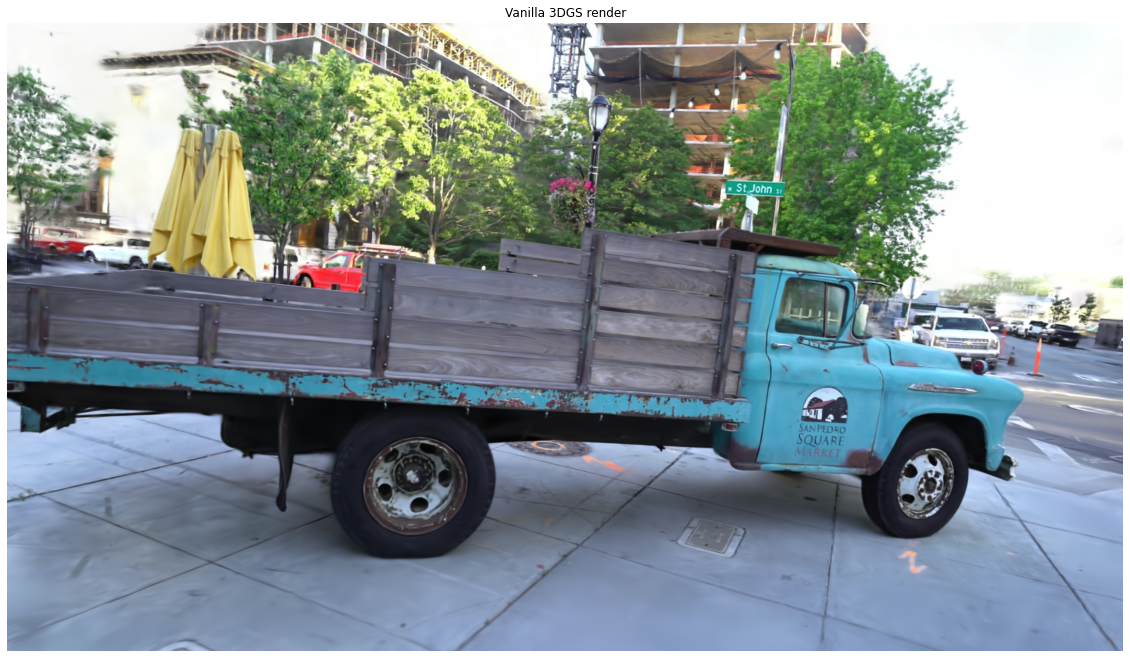

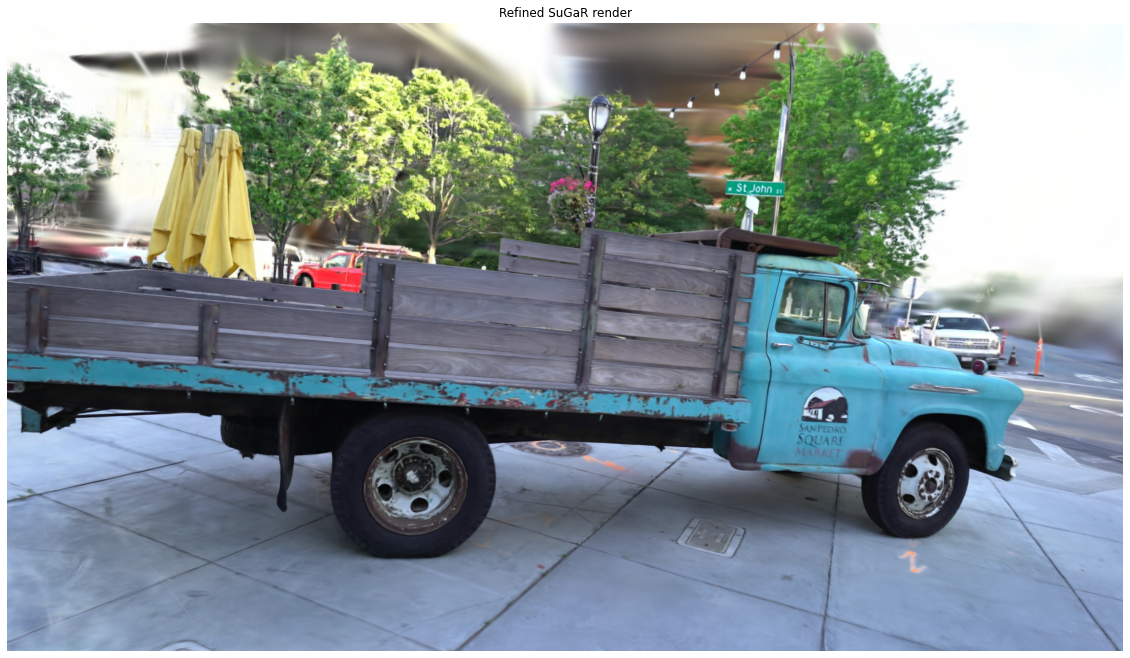

In [18]:
onsamerow = True
also_render_vanilla_3dgs = True

# -----Camera to render-----
cameras_to_use = nerfmodel.training_cameras
# cameras_to_use = nerfmodel.test_cameras

cam_idx = np.random.randint(0, len(cameras_to_use.gs_cameras))
# --------------------------

refined_sugar.eval()
refined_sugar.adapt_to_cameras(cameras_to_use)

print(f"Rendering image with index {cam_idx}.")
print("Image name:", cameras_to_use.gs_cameras[cam_idx].image_name)

verbose = False
normalize_img = False

if load_gt_images:
    gt_rgb = nerfmodel.get_gt_image(cam_idx)
    i_sugar = 2
else:
    i_sugar = 1

with torch.no_grad():
    if also_render_vanilla_3dgs:
        gs_image = nerfmodel.render_image(
            nerf_cameras=cameras_to_use,
            camera_indices=cam_idx).clamp(min=0, max=1)
    
    sugar_image = refined_sugar.render_image_gaussian_rasterizer(
        nerf_cameras=cameras_to_use, 
        camera_indices=cam_idx,
        # bg_color=1. * torch.Tensor([1.0, 1.0, 1.0]).to(rc_fine.device),
        sh_deg=nerfmodel.gaussians.active_sh_degree,
        compute_color_in_rasterizer=True,
    ).nan_to_num().clamp(min=0, max=1)

# Change this to adjust the size of the plot
plot_ratio = 2. # 0.7, 1.5, 5

if also_render_vanilla_3dgs:
    plt.figure(figsize=(10 * plot_ratio, 10 * plot_ratio))
    plt.axis("off")
    plt.title("Vanilla 3DGS render")
    plt.imshow(gs_image.cpu().numpy())
    plt.show()
plt.figure(figsize=(10 * plot_ratio, 10 * plot_ratio))
plt.axis("off")
plt.title("Refined SuGaR render")
plt.imshow(sugar_image.cpu().numpy())
plt.show()
torch.cuda.empty_cache()

# Render with a traditional color texture for SuGaR mesh

Select the path to the textured mesh (i.e. the obj file in `refined_mesh/<your scene>`).<br>
If None, the path to the mesh will be automatically computed from the checkpoint path.

In [15]:
refined_mesh_path = None

Load mesh.

In [16]:
if refined_mesh_path is None:
    post_processed = False

    if post_processed:
        post_processed_str = '_postprocessed'
    else:
        post_processed_str = ''

    scene_name = refined_sugar_path.split('/')[-3]
    refined_mesh_dir = './output/refined_mesh'
    refined_mesh_path = os.path.join(
        refined_mesh_dir, scene_name,
        refined_sugar_path.split('/')[-2].split('.')[0] + '.obj'
    )
    
print(f"Loading refined mesh from {refined_mesh_path}, this could take a minute...")
textured_mesh = load_objs_as_meshes([refined_mesh_path]).to(nerfmodel.device)
print(f"Loaded textured mesh with {len(textured_mesh.verts_list()[0])} vertices and {len(textured_mesh.faces_list()[0])} faces.")

Loading refined mesh from ./output/refined_mesh/undistorted/sugarfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1.obj, this could take a minute...


FileNotFoundError: [Errno 2] No such file or directory: 'output/refined_mesh/undistorted/sugarfine_3Dgs7000_densityestim02_sdfnorm02_level03_decim1000000_normalconsistency01_gaussperface1.obj'

In [ ]:
# -----Camera index to render-----
cam_idx = np.random.randint(0, len(cameras_to_use))
# --------------------------

faces_per_pixel = 1
max_faces_per_bin = 50_000

mesh_raster_settings = RasterizationSettings(
    image_size=(refined_sugar.image_height, refined_sugar.image_width),
    blur_radius=0.0, 
    faces_per_pixel=faces_per_pixel,
    # max_faces_per_bin=max_faces_per_bin
)
lights = AmbientLights(device=nerfmodel.device)
rasterizer = MeshRasterizer(
        cameras=cameras_to_use.p3d_cameras[cam_idx], 
        raster_settings=mesh_raster_settings,
    )
renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=SoftPhongShader(
        device=refined_sugar.device, 
        cameras=cameras_to_use.p3d_cameras[cam_idx],
        lights=lights,
        # blend_params=BlendParams(background_color=(0.0, 0.0, 0.0)),
        blend_params=BlendParams(background_color=(1.0, 1.0, 1.0)),
    )
)

with torch.no_grad():    
    print("Rendering image", cam_idx)
    print("Image ID:", cameras_to_use.gs_cameras[cam_idx].image_name)
    
    p3d_cameras = cameras_to_use.p3d_cameras[cam_idx]
    rgb_img = renderer(textured_mesh, cameras=p3d_cameras)[0, ..., :3]
    
# Change this to adjust the size of the plot
plot_ratio = 2.

plt.figure(figsize=(10 * plot_ratio, 10 * plot_ratio))
plt.axis("off")
plt.title("Refined SuGaR mesh with a traditional color UV texture")
plt.imshow(rgb_img.cpu().numpy())
plt.show()